In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v4 import ESN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2022-12-21 16:20:45.995884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-21 16:20:45.996434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 16:20:46.033306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 16:20:46.033564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 16:20:46.033855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 16:20:46.034045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ESN'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_026'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

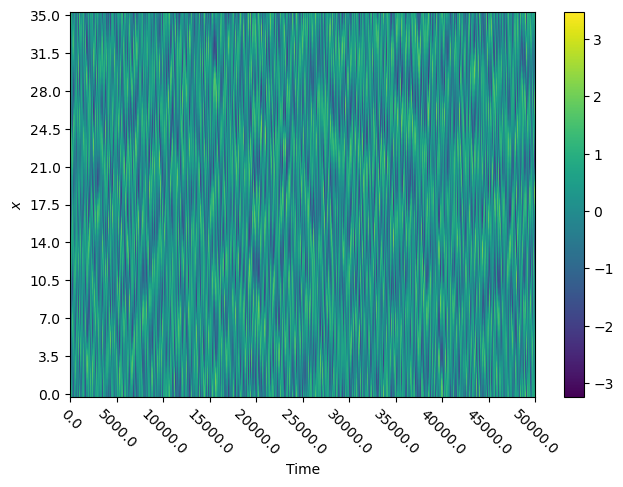

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

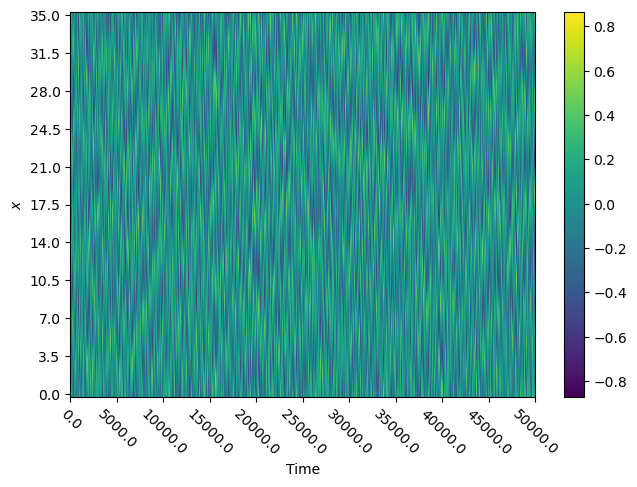

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

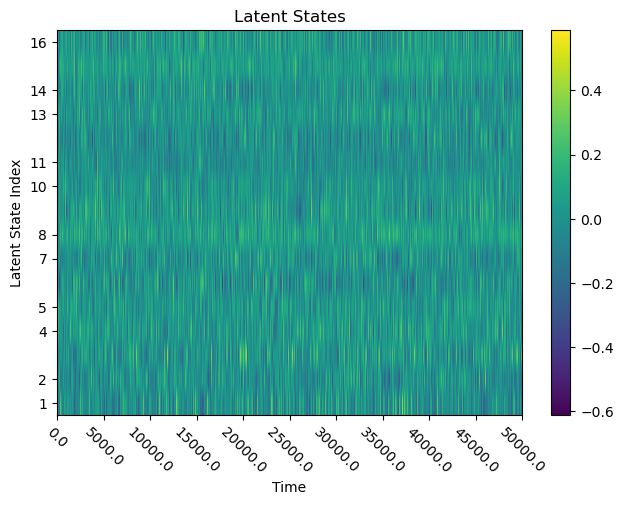

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# ESN

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.2
    num_input_tsteps = 375
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    ESN_layers_units = [500]
    stateful = True
    omega_in = [1.0]
    degree_of_connectivity = [10]
    rho_res = [0.5]
    usebias_Win = [False]
    alpha = [0.95]
    ESN_cell_activations = ['tanh']
    usebias_Wout = True
    
    activation_post_Wout = 'tanh'
    use_weights_post_dense = True
    
    # computing sparsity
    sparsity = [1-degree_of_connectivity[i]/(ESN_layers_units[i]-1) for i in range(len(ESN_layers_units))]
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr, # pointless, saved_data parameter
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset, # pointless, RNN parameter
        'stddev_multiplier':stddev_multiplier, # pointless, RNN parameter
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':ESN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    epochs = 3
    lambda_reg = 1e-4 # weight for regularizer
    min_delta = 1e-6
    patience = 5
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 1
    fRMS = 0.25/100
    use_best = False

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'epochs':epochs,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'lambda_reg':lambda_reg,
        'min_delta':min_delta,
        'patience':patience,
        'use_best':use_best,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    epochs = tparams_dict['epochs']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    lambda_reg = tparams_dict['lambda_reg']
    min_delta = tparams_dict['min_delta']
    patience = tparams_dict['patience']
    try:
        use_best = tparams_dict['use_best']
    except:
        print("'use_best' not present in 'training_specific_params', set to True.")
        use_best = True

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j::batch_size]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j::batch_size]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j::batch_size]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j::batch_size]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j::batch_size]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j::batch_size]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (531, 375, 16)
 testing_data_rnn_input.shape :  (67, 375, 16)
     val_data_rnn_input.shape :  (66, 375, 16)


In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states


    rnn_net = ESN(
        data_dim=data_dim,
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        ESN_layers_units=ESN_layers_units,
        stddev=stddev,
        noise_type=noise_type,
        stateful=stateful,
        omega_in=omega_in,
        sparsity=sparsity,
        rho_res=rho_res,
        usebias_Win=usebias_Win,
        alpha=alpha,
        ESN_cell_activations=ESN_cell_activations,
        prng_seed=prng_seed,
        usebias_Wout=usebias_Wout,
        use_weights_post_dense=use_weights_post_dense,
        activation_post_Wout=activation_post_Wout,
    )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.build(input_shape=(1,) + training_data_rnn_input.shape[1:])
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = ESN(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.hdf5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.000826655924320221


In [31]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
# elif behaviour == 'loadCheckpointAndContinueTraining':
#     val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
#         dir_name_ae=dir_name_rnn,
#         dir_sep=dir_sep,
#         epochs=epochs,
#         learning_rate_list=learning_rate_list,
#         return_earlystopping_wait=True)
#     savelosses_cb_vallossarr = val_loss_arr_fromckpt
#     savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change_sgd']
    test_loss = losses_dict['test_mse']

In [32]:
# def invert_fn(y):
#     # post_Wout_activation = 'linear'
#     return y

def invert_fn(y):
    # post_Wout_activation = 'tanh'
    y = np.where(y < 1.0, y, 1-1e-6)
    y = np.where(y > -1.0, y, -1+1e-6)
    y = 0.5*(np.log(1+y) - np.log(1-y))
    return y
    

In [33]:
training_data_rnn_input.dtype

dtype('float64')

In [34]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=losses.MeanSquaredError(),
    metrics=['mse'],
    run_eagerly=False
)

lambda_reg = float(lambda_reg)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    rnn_net.load_weights(wt_file)
    
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':

    Wout_best = 0
    val_mse_best = np.inf
    Wout_candidate = 0
    wait = 0
    if use_weights_post_dense == True:
        postWout_candidate = 0
        h_activation = tf.keras.activations.get(activation_post_Wout)
    
    
    hidden_units = ESN_layers_units[-1]
    output_units = rnn_net.data_dim
    
    Hb_shape = [hidden_units, hidden_units]
    Yb_shape = [output_units, hidden_units]
    if usebias_Wout == True:
        Hb_shape[0] += 1
        Hb_shape[1] += 1
        Yb_shape[1] += 1
        
    Hb = np.zeros(shape=Hb_shape, dtype=FTYPE)
    Yb = np.zeros(shape=Yb_shape, dtype=FTYPE)
    eye_Hb = np.eye(Hb.shape[0], dtype=FTYPE)

    num_batches = training_data_rnn_input.shape[0]
    
    
    for i in range(epochs):
        # for layer in rnn_net.ESN_layers:
        #     layer.reset_states()

        epoch_totaltime = time.time()

        total_s_len = 80
        sep_lr_s = ' EPOCH : {} '.format(i+1)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')

        # '''
        ### computing Wout
        Hb = 0
        Yb = 0
        epoch_time = time.time()
        for j in range(training_data_rnn_input.shape[0]):
            batch_time = time.time()
            h = np.array(rnn_net(training_data_rnn_input[j:j+1], manual_training=True))
            # h = rnn_net(training_data_rnn_input[j:j+1], training=True)
            # print(h.shape)
            h = h[0]
            # y = tf.constant(training_data_rnn_output[j])
            y = invert_fn(training_data_rnn_output[j])
            if usebias_Wout == True:
                h = np.concatenate((h, np.ones(shape=(h.shape[0], 1))), axis=1)
            Hb = Hb + np.matmul(np.transpose(h), h)
            Yb = Yb + np.matmul(np.transpose(y), h)
            # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
            # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)

            print('{} / {} -- Wout batch_time : {} sec'.format(
                j+1,
                training_data_rnn_input.shape[0],
                time.time() - batch_time
            ))

        Wout = np.matmul(
            Yb,
            np.linalg.inv(Hb + lambda_reg*np.eye(Hb.shape[0]))
        )
        Wout = np.transpose(Wout)
        # Wout = tf.linalg.matmul(
        #     Yb,
        #     tf.linalg.inv(Hb + lambda_reg*tf.eye(Hb.shape[0]))
        # )
        # Wout = tf.transpose(Wout)
        
        if use_weights_post_dense == True:
            ### computing postWout
            HYb = 0
            HHb = 0
            for j in range(training_data_rnn_input.shape[0]):
                batch_time = time.time()
                h = np.array(rnn_net(training_data_rnn_input[j:j+1], manual_training=True))
                # h = rnn_net(training_data_rnn_input[j:j+1], training=True)
                # print(h.shape)
                h = h[0]
                h = np.matmul(h, Wout[0:ESN_layers_units[-1], :])
                if usebias_Wout == True:
                    h = h + Wout[ESN_layers_units[-1]:, :]
                # y = tf.constant(training_data_rnn_output[j])
                h = np.array(h_activation(h))
                y = training_data_rnn_output[j]
                HYb = HYb + np.sum(h*y, axis=0)
                HHb = HHb + np.sum(h**2, axis=0)
                # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
                # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)

                print('{} / {} -- postWout batch_time : {} sec'.format(
                    j+1,
                    training_data_rnn_input.shape[0],
                    time.time() - batch_time
                ))
                
            postWout = HYb / (HHb + lambda_reg)

        print('\nepoch_time : {} sec'.format(time.time() - epoch_time))
        
        '''
        epoch_time = time.time()
        Wout = batched_computation(
            num_batches,
            rnn_net,
            training_data_rnn_input,
            training_data_rnn_output,
            usebias_Wout,
            Hb, Yb,
            hidden_units, output_units,
            lambda_reg, eye_Hb)
        print('\nepoch_time : {} sec'.format(time.time() - epoch_time))

        Hb[:, :] = 0.0
        Yb[:, :] = 0.0
        '''
    
        Wout_candidate = Wout_candidate*i/(i+1) + Wout*1/(i+1)
        tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_candidate[0:ESN_layers_units[-1], :])
        if usebias_Wout == True:
            tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_candidate[-1, :])

        if use_weights_post_dense == True:
            postWout_candidate = postWout_candidate*i/(i+1) + postWout*1/(i+1)
            tf.keras.backend.set_value(rnn_net.postWout.individual_weights, postWout_candidate)

        for layer in rnn_net.ESN_layers:
            layer.reset_states()

        print('\nval mse')
        # '''
        val_mse = 0
        for j in range(val_data_rnn_input.shape[0]):
            batch_time = time.time()
            val_pred = np.array(rnn_net(val_data_rnn_input[j:j+1], manual_training=False))
            temp = (val_pred - val_data_rnn_output[j:j+1])**2
            temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
            temp = np.mean(temp, axis=-1)
            temp = np.mean(temp, axis=-1)
            val_mse = val_mse*j/(j+1) + temp*1/(j+1)
            print('{} / {} -- batch_time : {} sec'.format(
                j+1,
                val_data_rnn_input.shape[0],
                time.time() - batch_time
            ))
        '''
        mse_time = time.time()
        val_mse = compute_mse(
            val_data_rnn_input,
            val_data_rnn_output,
            rnn_net)
        mse_time = time.time() - mse_time
        print('val_mse compute time : {} sec'.format(mse_time))
        '''

        for layer in rnn_net.ESN_layers:
            layer.reset_states()

        print('\ntraining mse')
        # '''
        train_mse = 0
        for j in range(training_data_rnn_input.shape[0]):
            batch_time = time.time()
            train_pred = np.array(rnn_net(training_data_rnn_input[j:j+1], manual_training=False))
            temp = (train_pred - training_data_rnn_output[j:j+1])**2
            temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
            temp = np.mean(temp, axis=-1)
            temp = np.mean(temp, axis=-1)
            train_mse = train_mse*j/(j+1) + temp*1/(j+1)
            print('{} / {} -- batch_time : {} sec'.format(
                j+1,
                training_data_rnn_input.shape[0],
                time.time() - batch_time
            ))
        '''
        mse_time = time.time()
        train_mse = compute_mse(
            training_data_rnn_input,
            training_data_rnn_output,
            rnn_net)
        mse_time = time.time() - mse_time
        print('train_mse compute time : {} sec'.format(mse_time))
        '''

        for layer in rnn_net.ESN_layers:
            layer.reset_states()

#         print('\ntesting mse')
#         test_mse = 0
#         for j in range(testing_data_rnn_input.shape[0]):
#             print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
#             test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], training=False))
#             temp = (test_pred - testing_data_rnn_output[j:j+1])**2
#             temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
#             temp = np.mean(temp, axis=-1)
#             temp = np.mean(temp, axis=-1)
#             test_mse = test_mse*j/(j+1) + temp*1/(j+1)
        
#         for layer in rnn_net.ESN_layers:
#             layer.reset_states()

        val_loss_hist.append(val_mse)
        train_loss_hist.append(train_mse)
        
        # print('\ntest_mse : {}'.format(test_mse))
        print('\ntrain_mse : {}'.format(train_mse))
        print('val_mse : {}'.format(val_mse))
        if val_mse + min_delta <= val_mse_best:
            print('val_mse improved from {}'.format(val_mse_best))
            Wout_best = Wout_candidate
            val_mse_best = val_mse
            wait = 0
        else:
            wait += 1
            print('val_mse did not improve from {}, wait : {}'.format(val_mse_best, wait))

        print('\nTotal epoch computation time : {} sec'.format(time.time()-epoch_totaltime))
            
        if wait >= patience:
            print('\nearly stopping')
            break
        
#         val_loss_hist.extend(history.history['val_loss'])
#         train_loss_hist.extend(history.history['loss'])
        
#         if i == starting_lr_idx:
#             lr_change[i+1] += len(history.history['val_loss'])
#         else:
#             lr_change.append(lr_change[i]+len(history.history['val_loss']))

# tf.keras.backend.set_value(rnn_net.Wout, Wout_best)

if use_best == True:
    tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_best[0:ESN_layers_units[-1], :])
    if usebias_Wout == True:
        tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_best[-1, :])
print('\ntest mse')
test_mse = 0
for j in range(testing_data_rnn_input.shape[0]):
    print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
    test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], manual_training=False))
    temp = (test_pred - testing_data_rnn_output[j:j+1])**2
    temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
    temp = np.mean(temp, axis=-1)
    temp = np.mean(temp, axis=-1)
    test_mse = test_mse*j/(j+1) + temp*1/(j+1)
print('test_mse : {}'.format(test_mse))

for layer in rnn_net.ESN_layers:
    layer.reset_states()



--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 531 -- Wout batch_time : 0.20769429206848145 sec
2 / 531 -- Wout batch_time : 0.08508062362670898 sec
3 / 531 -- Wout batch_time : 0.06466865539550781 sec
4 / 531 -- Wout batch_time : 0.0542144775390625 sec
5 / 531 -- Wout batch_time : 0.0980219841003418 sec
6 / 531 -- Wout batch_time : 0.06606388092041016 sec
7 / 531 -- Wout batch_time : 0.05479121208190918 sec
8 / 531 -- Wout batch_time : 0.06681442260742188 sec
9 / 531 -- Wout batch_time : 0.08533453941345215 sec
10 / 531 -- Wout batch_time : 0.056978464126586914 sec
11 / 531 -- Wout batch_time : 0.05626273155212402 sec
12 / 531 -- Wout batch_time : 0.0600888729095459 sec
13 / 531 -- Wout batch_time : 0.09715151786804199 sec
14 / 531 -- Wout batch_time : 0.10709547996520996 sec
15 / 5

149 / 531 -- Wout batch_time : 0.05465245246887207 sec
150 / 531 -- Wout batch_time : 0.06306910514831543 sec
151 / 531 -- Wout batch_time : 0.05492758750915527 sec
152 / 531 -- Wout batch_time : 0.05672955513000488 sec
153 / 531 -- Wout batch_time : 0.07668113708496094 sec
154 / 531 -- Wout batch_time : 0.05461931228637695 sec
155 / 531 -- Wout batch_time : 0.05590224266052246 sec
156 / 531 -- Wout batch_time : 0.10333561897277832 sec
157 / 531 -- Wout batch_time : 0.055373191833496094 sec
158 / 531 -- Wout batch_time : 0.052933692932128906 sec
159 / 531 -- Wout batch_time : 0.05133223533630371 sec
160 / 531 -- Wout batch_time : 0.06006646156311035 sec
161 / 531 -- Wout batch_time : 0.08642029762268066 sec
162 / 531 -- Wout batch_time : 0.05925703048706055 sec
163 / 531 -- Wout batch_time : 0.06527137756347656 sec
164 / 531 -- Wout batch_time : 0.07216906547546387 sec
165 / 531 -- Wout batch_time : 0.0746302604675293 sec
166 / 531 -- Wout batch_time : 0.07241678237915039 sec
167 / 531

300 / 531 -- Wout batch_time : 0.08766293525695801 sec
301 / 531 -- Wout batch_time : 0.0592498779296875 sec
302 / 531 -- Wout batch_time : 0.060117244720458984 sec
303 / 531 -- Wout batch_time : 0.05654764175415039 sec
304 / 531 -- Wout batch_time : 0.061922311782836914 sec
305 / 531 -- Wout batch_time : 0.055204153060913086 sec
306 / 531 -- Wout batch_time : 0.0762324333190918 sec
307 / 531 -- Wout batch_time : 0.08490872383117676 sec
308 / 531 -- Wout batch_time : 0.05463862419128418 sec
309 / 531 -- Wout batch_time : 0.0830535888671875 sec
310 / 531 -- Wout batch_time : 0.05292654037475586 sec
311 / 531 -- Wout batch_time : 0.05599331855773926 sec
312 / 531 -- Wout batch_time : 0.053907155990600586 sec
313 / 531 -- Wout batch_time : 0.05128741264343262 sec
314 / 531 -- Wout batch_time : 0.05689811706542969 sec
315 / 531 -- Wout batch_time : 0.06790542602539062 sec
316 / 531 -- Wout batch_time : 0.053205251693725586 sec
317 / 531 -- Wout batch_time : 0.044756412506103516 sec
318 / 5

451 / 531 -- Wout batch_time : 0.0681309700012207 sec
452 / 531 -- Wout batch_time : 0.060407161712646484 sec
453 / 531 -- Wout batch_time : 0.058342933654785156 sec
454 / 531 -- Wout batch_time : 0.064483642578125 sec
455 / 531 -- Wout batch_time : 0.06194591522216797 sec
456 / 531 -- Wout batch_time : 0.05557894706726074 sec
457 / 531 -- Wout batch_time : 0.05679750442504883 sec
458 / 531 -- Wout batch_time : 0.06645011901855469 sec
459 / 531 -- Wout batch_time : 0.056799888610839844 sec
460 / 531 -- Wout batch_time : 0.05472540855407715 sec
461 / 531 -- Wout batch_time : 0.05416417121887207 sec
462 / 531 -- Wout batch_time : 0.05382800102233887 sec
463 / 531 -- Wout batch_time : 0.06253433227539062 sec
464 / 531 -- Wout batch_time : 0.05395340919494629 sec
465 / 531 -- Wout batch_time : 0.05523109436035156 sec
466 / 531 -- Wout batch_time : 0.08145666122436523 sec
467 / 531 -- Wout batch_time : 0.0970468521118164 sec
468 / 531 -- Wout batch_time : 0.10560035705566406 sec
469 / 531 -

68 / 531 -- postWout batch_time : 0.07403206825256348 sec
69 / 531 -- postWout batch_time : 0.05257558822631836 sec
70 / 531 -- postWout batch_time : 0.05170702934265137 sec
71 / 531 -- postWout batch_time : 0.0512235164642334 sec
72 / 531 -- postWout batch_time : 0.06539583206176758 sec
73 / 531 -- postWout batch_time : 0.05245637893676758 sec
74 / 531 -- postWout batch_time : 0.05164194107055664 sec
75 / 531 -- postWout batch_time : 0.05163741111755371 sec
76 / 531 -- postWout batch_time : 0.06280255317687988 sec
77 / 531 -- postWout batch_time : 0.05216479301452637 sec
78 / 531 -- postWout batch_time : 0.051859140396118164 sec
79 / 531 -- postWout batch_time : 0.051131486892700195 sec
80 / 531 -- postWout batch_time : 0.06413793563842773 sec
81 / 531 -- postWout batch_time : 0.053124189376831055 sec
82 / 531 -- postWout batch_time : 0.05169034004211426 sec
83 / 531 -- postWout batch_time : 0.05126953125 sec
84 / 531 -- postWout batch_time : 0.06827759742736816 sec
85 / 531 -- postWo

208 / 531 -- postWout batch_time : 0.08860349655151367 sec
209 / 531 -- postWout batch_time : 0.04989504814147949 sec
210 / 531 -- postWout batch_time : 0.05233049392700195 sec
211 / 531 -- postWout batch_time : 0.05130934715270996 sec
212 / 531 -- postWout batch_time : 0.07215452194213867 sec
213 / 531 -- postWout batch_time : 0.05230307579040527 sec
214 / 531 -- postWout batch_time : 0.05231976509094238 sec
215 / 531 -- postWout batch_time : 0.0539240837097168 sec
216 / 531 -- postWout batch_time : 0.08707761764526367 sec
217 / 531 -- postWout batch_time : 0.0536649227142334 sec
218 / 531 -- postWout batch_time : 0.05254650115966797 sec
219 / 531 -- postWout batch_time : 0.07132148742675781 sec
220 / 531 -- postWout batch_time : 0.08435964584350586 sec
221 / 531 -- postWout batch_time : 0.05875825881958008 sec
222 / 531 -- postWout batch_time : 0.05401802062988281 sec
223 / 531 -- postWout batch_time : 0.06394314765930176 sec
224 / 531 -- postWout batch_time : 0.05716896057128906 sec

350 / 531 -- postWout batch_time : 0.1006464958190918 sec
351 / 531 -- postWout batch_time : 0.05264735221862793 sec
352 / 531 -- postWout batch_time : 0.07492351531982422 sec
353 / 531 -- postWout batch_time : 0.06747555732727051 sec
354 / 531 -- postWout batch_time : 0.07529306411743164 sec
355 / 531 -- postWout batch_time : 0.05981159210205078 sec
356 / 531 -- postWout batch_time : 0.058527231216430664 sec
357 / 531 -- postWout batch_time : 0.07610917091369629 sec
358 / 531 -- postWout batch_time : 0.07056856155395508 sec
359 / 531 -- postWout batch_time : 0.06148338317871094 sec
360 / 531 -- postWout batch_time : 0.05300712585449219 sec
361 / 531 -- postWout batch_time : 0.06748008728027344 sec
362 / 531 -- postWout batch_time : 0.08202767372131348 sec
363 / 531 -- postWout batch_time : 0.06018710136413574 sec
364 / 531 -- postWout batch_time : 0.08037805557250977 sec
365 / 531 -- postWout batch_time : 0.05221986770629883 sec
366 / 531 -- postWout batch_time : 0.05261564254760742 s

492 / 531 -- postWout batch_time : 0.07581973075866699 sec
493 / 531 -- postWout batch_time : 0.052930355072021484 sec
494 / 531 -- postWout batch_time : 0.052240848541259766 sec
495 / 531 -- postWout batch_time : 0.05351972579956055 sec
496 / 531 -- postWout batch_time : 0.08083033561706543 sec
497 / 531 -- postWout batch_time : 0.05238628387451172 sec
498 / 531 -- postWout batch_time : 0.05166959762573242 sec
499 / 531 -- postWout batch_time : 0.05157804489135742 sec
500 / 531 -- postWout batch_time : 0.06150007247924805 sec
501 / 531 -- postWout batch_time : 0.05985546112060547 sec
502 / 531 -- postWout batch_time : 0.05214428901672363 sec
503 / 531 -- postWout batch_time : 0.051038265228271484 sec
504 / 531 -- postWout batch_time : 0.06677985191345215 sec
505 / 531 -- postWout batch_time : 0.06323027610778809 sec
506 / 531 -- postWout batch_time : 0.0513002872467041 sec
507 / 531 -- postWout batch_time : 0.05122733116149902 sec
508 / 531 -- postWout batch_time : 0.06973481178283691

57 / 531 -- batch_time : 0.16420769691467285 sec
58 / 531 -- batch_time : 0.17649602890014648 sec
59 / 531 -- batch_time : 0.17342495918273926 sec
60 / 531 -- batch_time : 0.1566178798675537 sec
61 / 531 -- batch_time : 0.18280959129333496 sec
62 / 531 -- batch_time : 0.1670522689819336 sec
63 / 531 -- batch_time : 0.16831111907958984 sec
64 / 531 -- batch_time : 0.16779112815856934 sec
65 / 531 -- batch_time : 0.16856598854064941 sec
66 / 531 -- batch_time : 0.16693854331970215 sec
67 / 531 -- batch_time : 0.2216968536376953 sec
68 / 531 -- batch_time : 0.15624046325683594 sec
69 / 531 -- batch_time : 0.18758082389831543 sec
70 / 531 -- batch_time : 0.18134713172912598 sec
71 / 531 -- batch_time : 0.16381359100341797 sec
72 / 531 -- batch_time : 0.1694505214691162 sec
73 / 531 -- batch_time : 0.16101479530334473 sec
74 / 531 -- batch_time : 0.15572071075439453 sec
75 / 531 -- batch_time : 0.1614382266998291 sec
76 / 531 -- batch_time : 0.16032671928405762 sec
77 / 531 -- batch_time : 

223 / 531 -- batch_time : 0.18208551406860352 sec
224 / 531 -- batch_time : 0.20593857765197754 sec
225 / 531 -- batch_time : 0.1579272747039795 sec
226 / 531 -- batch_time : 0.15817546844482422 sec
227 / 531 -- batch_time : 0.1937255859375 sec
228 / 531 -- batch_time : 0.18534135818481445 sec
229 / 531 -- batch_time : 0.16700148582458496 sec
230 / 531 -- batch_time : 0.16201305389404297 sec
231 / 531 -- batch_time : 0.1692812442779541 sec
232 / 531 -- batch_time : 0.1636650562286377 sec
233 / 531 -- batch_time : 0.16515135765075684 sec
234 / 531 -- batch_time : 0.199920654296875 sec
235 / 531 -- batch_time : 0.19460201263427734 sec
236 / 531 -- batch_time : 0.17691397666931152 sec
237 / 531 -- batch_time : 0.20216083526611328 sec
238 / 531 -- batch_time : 0.15458893775939941 sec
239 / 531 -- batch_time : 0.15204215049743652 sec
240 / 531 -- batch_time : 0.16729164123535156 sec
241 / 531 -- batch_time : 0.1757190227508545 sec
242 / 531 -- batch_time : 0.16240859031677246 sec
243 / 531 

388 / 531 -- batch_time : 0.1649007797241211 sec
389 / 531 -- batch_time : 0.17361903190612793 sec
390 / 531 -- batch_time : 0.1907973289489746 sec
391 / 531 -- batch_time : 0.17999744415283203 sec
392 / 531 -- batch_time : 0.17254996299743652 sec
393 / 531 -- batch_time : 0.16667962074279785 sec
394 / 531 -- batch_time : 0.1744229793548584 sec
395 / 531 -- batch_time : 0.1670830249786377 sec
396 / 531 -- batch_time : 0.17562031745910645 sec
397 / 531 -- batch_time : 0.18768095970153809 sec
398 / 531 -- batch_time : 0.15415692329406738 sec
399 / 531 -- batch_time : 0.15369629859924316 sec
400 / 531 -- batch_time : 0.1712806224822998 sec
401 / 531 -- batch_time : 0.14959383010864258 sec
402 / 531 -- batch_time : 0.17340564727783203 sec
403 / 531 -- batch_time : 0.1688852310180664 sec
404 / 531 -- batch_time : 0.17481756210327148 sec
405 / 531 -- batch_time : 0.15838122367858887 sec
406 / 531 -- batch_time : 0.17545437812805176 sec
407 / 531 -- batch_time : 0.16430354118347168 sec
408 / 

15 / 531 -- Wout batch_time : 0.08711004257202148 sec
16 / 531 -- Wout batch_time : 0.054863929748535156 sec
17 / 531 -- Wout batch_time : 0.054094552993774414 sec
18 / 531 -- Wout batch_time : 0.0559694766998291 sec
19 / 531 -- Wout batch_time : 0.08236217498779297 sec
20 / 531 -- Wout batch_time : 0.054818153381347656 sec
21 / 531 -- Wout batch_time : 0.0545654296875 sec
22 / 531 -- Wout batch_time : 0.0548858642578125 sec
23 / 531 -- Wout batch_time : 0.08310747146606445 sec
24 / 531 -- Wout batch_time : 0.054337263107299805 sec
25 / 531 -- Wout batch_time : 0.054669857025146484 sec
26 / 531 -- Wout batch_time : 0.05453228950500488 sec
27 / 531 -- Wout batch_time : 0.08414578437805176 sec
28 / 531 -- Wout batch_time : 0.05435943603515625 sec
29 / 531 -- Wout batch_time : 0.05453038215637207 sec
30 / 531 -- Wout batch_time : 0.05440187454223633 sec
31 / 531 -- Wout batch_time : 0.07827877998352051 sec
32 / 531 -- Wout batch_time : 0.05343818664550781 sec
33 / 531 -- Wout batch_time :

166 / 531 -- Wout batch_time : 0.10611081123352051 sec
167 / 531 -- Wout batch_time : 0.05450439453125 sec
168 / 531 -- Wout batch_time : 0.059858083724975586 sec
169 / 531 -- Wout batch_time : 0.04929351806640625 sec
170 / 531 -- Wout batch_time : 0.07004976272583008 sec
171 / 531 -- Wout batch_time : 0.0511629581451416 sec
172 / 531 -- Wout batch_time : 0.049208879470825195 sec
173 / 531 -- Wout batch_time : 0.08308196067810059 sec
174 / 531 -- Wout batch_time : 0.06558012962341309 sec
175 / 531 -- Wout batch_time : 0.05666637420654297 sec
176 / 531 -- Wout batch_time : 0.05372762680053711 sec
177 / 531 -- Wout batch_time : 0.054236412048339844 sec
178 / 531 -- Wout batch_time : 0.07927727699279785 sec
179 / 531 -- Wout batch_time : 0.05265164375305176 sec
180 / 531 -- Wout batch_time : 0.05398058891296387 sec
181 / 531 -- Wout batch_time : 0.053379058837890625 sec
182 / 531 -- Wout batch_time : 0.07651329040527344 sec
183 / 531 -- Wout batch_time : 0.06429457664489746 sec
184 / 531 

318 / 531 -- Wout batch_time : 0.08448529243469238 sec
319 / 531 -- Wout batch_time : 0.05416393280029297 sec
320 / 531 -- Wout batch_time : 0.05401015281677246 sec
321 / 531 -- Wout batch_time : 0.053838253021240234 sec
322 / 531 -- Wout batch_time : 0.13328886032104492 sec
323 / 531 -- Wout batch_time : 0.05648541450500488 sec
324 / 531 -- Wout batch_time : 0.05542159080505371 sec
325 / 531 -- Wout batch_time : 0.07288908958435059 sec
326 / 531 -- Wout batch_time : 0.0708460807800293 sec
327 / 531 -- Wout batch_time : 0.06509280204772949 sec
328 / 531 -- Wout batch_time : 0.08270525932312012 sec
329 / 531 -- Wout batch_time : 0.09299945831298828 sec
330 / 531 -- Wout batch_time : 0.05207562446594238 sec
331 / 531 -- Wout batch_time : 0.053708553314208984 sec
332 / 531 -- Wout batch_time : 0.04923272132873535 sec
333 / 531 -- Wout batch_time : 0.07084393501281738 sec
334 / 531 -- Wout batch_time : 0.06383633613586426 sec
335 / 531 -- Wout batch_time : 0.059380292892456055 sec
336 / 53

468 / 531 -- Wout batch_time : 0.08532476425170898 sec
469 / 531 -- Wout batch_time : 0.05374407768249512 sec
470 / 531 -- Wout batch_time : 0.053949832916259766 sec
471 / 531 -- Wout batch_time : 0.05353999137878418 sec
472 / 531 -- Wout batch_time : 0.08274149894714355 sec
473 / 531 -- Wout batch_time : 0.05410361289978027 sec
474 / 531 -- Wout batch_time : 0.05451631546020508 sec
475 / 531 -- Wout batch_time : 0.054372549057006836 sec
476 / 531 -- Wout batch_time : 0.0844271183013916 sec
477 / 531 -- Wout batch_time : 0.05465817451477051 sec
478 / 531 -- Wout batch_time : 0.05430150032043457 sec
479 / 531 -- Wout batch_time : 0.05439949035644531 sec
480 / 531 -- Wout batch_time : 0.07047271728515625 sec
481 / 531 -- Wout batch_time : 0.054146766662597656 sec
482 / 531 -- Wout batch_time : 0.07158374786376953 sec
483 / 531 -- Wout batch_time : 0.05276608467102051 sec
484 / 531 -- Wout batch_time : 0.08282470703125 sec
485 / 531 -- Wout batch_time : 0.055558204650878906 sec
486 / 531 

82 / 531 -- postWout batch_time : 0.09014558792114258 sec
83 / 531 -- postWout batch_time : 0.08011031150817871 sec
84 / 531 -- postWout batch_time : 0.06314897537231445 sec
85 / 531 -- postWout batch_time : 0.05657768249511719 sec
86 / 531 -- postWout batch_time : 0.05971479415893555 sec
87 / 531 -- postWout batch_time : 0.053487300872802734 sec
88 / 531 -- postWout batch_time : 0.052307844161987305 sec
89 / 531 -- postWout batch_time : 0.053136348724365234 sec
90 / 531 -- postWout batch_time : 0.08707427978515625 sec
91 / 531 -- postWout batch_time : 0.05194592475891113 sec
92 / 531 -- postWout batch_time : 0.055678606033325195 sec
93 / 531 -- postWout batch_time : 0.05513453483581543 sec
94 / 531 -- postWout batch_time : 0.08109927177429199 sec
95 / 531 -- postWout batch_time : 0.05564427375793457 sec
96 / 531 -- postWout batch_time : 0.05217480659484863 sec
97 / 531 -- postWout batch_time : 0.05362892150878906 sec
98 / 531 -- postWout batch_time : 0.07572197914123535 sec
99 / 531 -

224 / 531 -- postWout batch_time : 0.06529569625854492 sec
225 / 531 -- postWout batch_time : 0.05177617073059082 sec
226 / 531 -- postWout batch_time : 0.06029629707336426 sec
227 / 531 -- postWout batch_time : 0.05428647994995117 sec
228 / 531 -- postWout batch_time : 0.07558417320251465 sec
229 / 531 -- postWout batch_time : 0.05249285697937012 sec
230 / 531 -- postWout batch_time : 0.05390429496765137 sec
231 / 531 -- postWout batch_time : 0.07727956771850586 sec
232 / 531 -- postWout batch_time : 0.06068277359008789 sec
233 / 531 -- postWout batch_time : 0.06713390350341797 sec
234 / 531 -- postWout batch_time : 0.05434107780456543 sec
235 / 531 -- postWout batch_time : 0.04712986946105957 sec
236 / 531 -- postWout batch_time : 0.07024931907653809 sec
237 / 531 -- postWout batch_time : 0.04659128189086914 sec
238 / 531 -- postWout batch_time : 0.04635047912597656 sec
239 / 531 -- postWout batch_time : 0.06029653549194336 sec
240 / 531 -- postWout batch_time : 0.07050156593322754 s

364 / 531 -- postWout batch_time : 0.061781883239746094 sec
365 / 531 -- postWout batch_time : 0.051508426666259766 sec
366 / 531 -- postWout batch_time : 0.056215524673461914 sec
367 / 531 -- postWout batch_time : 0.0514369010925293 sec
368 / 531 -- postWout batch_time : 0.0694575309753418 sec
369 / 531 -- postWout batch_time : 0.05247640609741211 sec
370 / 531 -- postWout batch_time : 0.05749082565307617 sec
371 / 531 -- postWout batch_time : 0.05862116813659668 sec
372 / 531 -- postWout batch_time : 0.07604384422302246 sec
373 / 531 -- postWout batch_time : 0.07180047035217285 sec
374 / 531 -- postWout batch_time : 0.05195355415344238 sec
375 / 531 -- postWout batch_time : 0.057018280029296875 sec
376 / 531 -- postWout batch_time : 0.05515718460083008 sec
377 / 531 -- postWout batch_time : 0.05549812316894531 sec
378 / 531 -- postWout batch_time : 0.05359315872192383 sec
379 / 531 -- postWout batch_time : 0.06385207176208496 sec
380 / 531 -- postWout batch_time : 0.07363748550415039

506 / 531 -- postWout batch_time : 0.06429505348205566 sec
507 / 531 -- postWout batch_time : 0.0523836612701416 sec
508 / 531 -- postWout batch_time : 0.052103281021118164 sec
509 / 531 -- postWout batch_time : 0.051810264587402344 sec
510 / 531 -- postWout batch_time : 0.09841275215148926 sec
511 / 531 -- postWout batch_time : 0.05783963203430176 sec
512 / 531 -- postWout batch_time : 0.0678708553314209 sec
513 / 531 -- postWout batch_time : 0.05842924118041992 sec
514 / 531 -- postWout batch_time : 0.06573295593261719 sec
515 / 531 -- postWout batch_time : 0.05705380439758301 sec
516 / 531 -- postWout batch_time : 0.05737876892089844 sec
517 / 531 -- postWout batch_time : 0.05253863334655762 sec
518 / 531 -- postWout batch_time : 0.07164120674133301 sec
519 / 531 -- postWout batch_time : 0.052618980407714844 sec
520 / 531 -- postWout batch_time : 0.06931328773498535 sec
521 / 531 -- postWout batch_time : 0.07457661628723145 sec
522 / 531 -- postWout batch_time : 0.05471682548522949 

74 / 531 -- batch_time : 0.16795706748962402 sec
75 / 531 -- batch_time : 0.1504497528076172 sec
76 / 531 -- batch_time : 0.15429067611694336 sec
77 / 531 -- batch_time : 0.14918875694274902 sec
78 / 531 -- batch_time : 0.1700575351715088 sec
79 / 531 -- batch_time : 0.17081403732299805 sec
80 / 531 -- batch_time : 0.1914820671081543 sec
81 / 531 -- batch_time : 0.16249346733093262 sec
82 / 531 -- batch_time : 0.18845486640930176 sec
83 / 531 -- batch_time : 0.19660449028015137 sec
84 / 531 -- batch_time : 0.17288613319396973 sec
85 / 531 -- batch_time : 0.16288399696350098 sec
86 / 531 -- batch_time : 0.1661982536315918 sec
87 / 531 -- batch_time : 0.15842509269714355 sec
88 / 531 -- batch_time : 0.17798805236816406 sec
89 / 531 -- batch_time : 0.15327835083007812 sec
90 / 531 -- batch_time : 0.15571379661560059 sec
91 / 531 -- batch_time : 0.14879608154296875 sec
92 / 531 -- batch_time : 0.18048644065856934 sec
93 / 531 -- batch_time : 0.17403483390808105 sec
94 / 531 -- batch_time :

240 / 531 -- batch_time : 0.15335869789123535 sec
241 / 531 -- batch_time : 0.16403889656066895 sec
242 / 531 -- batch_time : 0.17763328552246094 sec
243 / 531 -- batch_time : 0.1727581024169922 sec
244 / 531 -- batch_time : 0.17556214332580566 sec
245 / 531 -- batch_time : 0.18021416664123535 sec
246 / 531 -- batch_time : 0.1558678150177002 sec
247 / 531 -- batch_time : 0.17873001098632812 sec
248 / 531 -- batch_time : 0.1710207462310791 sec
249 / 531 -- batch_time : 0.17810416221618652 sec
250 / 531 -- batch_time : 0.15062856674194336 sec
251 / 531 -- batch_time : 0.1654980182647705 sec
252 / 531 -- batch_time : 0.15060067176818848 sec
253 / 531 -- batch_time : 0.1578693389892578 sec
254 / 531 -- batch_time : 0.16790246963500977 sec
255 / 531 -- batch_time : 0.1971280574798584 sec
256 / 531 -- batch_time : 0.18556666374206543 sec
257 / 531 -- batch_time : 0.18032217025756836 sec
258 / 531 -- batch_time : 0.18257546424865723 sec
259 / 531 -- batch_time : 0.15153932571411133 sec
260 / 

406 / 531 -- batch_time : 0.15145659446716309 sec
407 / 531 -- batch_time : 0.17430901527404785 sec
408 / 531 -- batch_time : 0.15494561195373535 sec
409 / 531 -- batch_time : 0.1486189365386963 sec
410 / 531 -- batch_time : 0.15151166915893555 sec
411 / 531 -- batch_time : 0.18500375747680664 sec
412 / 531 -- batch_time : 0.17217731475830078 sec
413 / 531 -- batch_time : 0.14971232414245605 sec
414 / 531 -- batch_time : 0.1517622470855713 sec
415 / 531 -- batch_time : 0.17990922927856445 sec
416 / 531 -- batch_time : 0.1569976806640625 sec
417 / 531 -- batch_time : 0.14985179901123047 sec
418 / 531 -- batch_time : 0.16389036178588867 sec
419 / 531 -- batch_time : 0.14935874938964844 sec
420 / 531 -- batch_time : 0.16065001487731934 sec
421 / 531 -- batch_time : 0.17996954917907715 sec
422 / 531 -- batch_time : 0.17067694664001465 sec
423 / 531 -- batch_time : 0.15738415718078613 sec
424 / 531 -- batch_time : 0.151045560836792 sec
425 / 531 -- batch_time : 0.17604851722717285 sec
426 /

30 / 531 -- Wout batch_time : 0.11631226539611816 sec
31 / 531 -- Wout batch_time : 0.05918717384338379 sec
32 / 531 -- Wout batch_time : 0.05615687370300293 sec
33 / 531 -- Wout batch_time : 0.06183147430419922 sec
34 / 531 -- Wout batch_time : 0.09322190284729004 sec
35 / 531 -- Wout batch_time : 0.09177994728088379 sec
36 / 531 -- Wout batch_time : 0.06186413764953613 sec
37 / 531 -- Wout batch_time : 0.0928962230682373 sec
38 / 531 -- Wout batch_time : 0.05302119255065918 sec
39 / 531 -- Wout batch_time : 0.058237314224243164 sec
40 / 531 -- Wout batch_time : 0.054361820220947266 sec
41 / 531 -- Wout batch_time : 0.07711195945739746 sec
42 / 531 -- Wout batch_time : 0.061309814453125 sec
43 / 531 -- Wout batch_time : 0.05430746078491211 sec
44 / 531 -- Wout batch_time : 0.08036518096923828 sec
45 / 531 -- Wout batch_time : 0.06559228897094727 sec
46 / 531 -- Wout batch_time : 0.0549471378326416 sec
47 / 531 -- Wout batch_time : 0.05741691589355469 sec
48 / 531 -- Wout batch_time : 

182 / 531 -- Wout batch_time : 0.08996462821960449 sec
183 / 531 -- Wout batch_time : 0.0650935173034668 sec
184 / 531 -- Wout batch_time : 0.05853414535522461 sec
185 / 531 -- Wout batch_time : 0.06380629539489746 sec
186 / 531 -- Wout batch_time : 0.08351707458496094 sec
187 / 531 -- Wout batch_time : 0.09323382377624512 sec
188 / 531 -- Wout batch_time : 0.05851411819458008 sec
189 / 531 -- Wout batch_time : 0.09873151779174805 sec
190 / 531 -- Wout batch_time : 0.047971487045288086 sec
191 / 531 -- Wout batch_time : 0.05472421646118164 sec
192 / 531 -- Wout batch_time : 0.055251121520996094 sec
193 / 531 -- Wout batch_time : 0.060884714126586914 sec
194 / 531 -- Wout batch_time : 0.0635673999786377 sec
195 / 531 -- Wout batch_time : 0.053943634033203125 sec
196 / 531 -- Wout batch_time : 0.05490851402282715 sec
197 / 531 -- Wout batch_time : 0.07107353210449219 sec
198 / 531 -- Wout batch_time : 0.0539708137512207 sec
199 / 531 -- Wout batch_time : 0.05461716651916504 sec
200 / 531

332 / 531 -- Wout batch_time : 0.06065225601196289 sec
333 / 531 -- Wout batch_time : 0.06578302383422852 sec
334 / 531 -- Wout batch_time : 0.05862784385681152 sec
335 / 531 -- Wout batch_time : 0.05520057678222656 sec
336 / 531 -- Wout batch_time : 0.07021689414978027 sec
337 / 531 -- Wout batch_time : 0.060144662857055664 sec
338 / 531 -- Wout batch_time : 0.07078123092651367 sec
339 / 531 -- Wout batch_time : 0.0995476245880127 sec
340 / 531 -- Wout batch_time : 0.06276965141296387 sec
341 / 531 -- Wout batch_time : 0.1000521183013916 sec
342 / 531 -- Wout batch_time : 0.09544706344604492 sec
343 / 531 -- Wout batch_time : 0.07193851470947266 sec
344 / 531 -- Wout batch_time : 0.06136345863342285 sec
345 / 531 -- Wout batch_time : 0.057596445083618164 sec
346 / 531 -- Wout batch_time : 0.07285737991333008 sec
347 / 531 -- Wout batch_time : 0.0910959243774414 sec
348 / 531 -- Wout batch_time : 0.06320023536682129 sec
349 / 531 -- Wout batch_time : 0.0869905948638916 sec
350 / 531 --

485 / 531 -- Wout batch_time : 0.09399104118347168 sec
486 / 531 -- Wout batch_time : 0.05424857139587402 sec
487 / 531 -- Wout batch_time : 0.053915977478027344 sec
488 / 531 -- Wout batch_time : 0.053696632385253906 sec
489 / 531 -- Wout batch_time : 0.09223818778991699 sec
490 / 531 -- Wout batch_time : 0.06298947334289551 sec
491 / 531 -- Wout batch_time : 0.09025406837463379 sec
492 / 531 -- Wout batch_time : 0.09106779098510742 sec
493 / 531 -- Wout batch_time : 0.05858469009399414 sec
494 / 531 -- Wout batch_time : 0.09138989448547363 sec
495 / 531 -- Wout batch_time : 0.0881960391998291 sec
496 / 531 -- Wout batch_time : 0.09372663497924805 sec
497 / 531 -- Wout batch_time : 0.05826997756958008 sec
498 / 531 -- Wout batch_time : 0.05861163139343262 sec
499 / 531 -- Wout batch_time : 0.05505251884460449 sec
500 / 531 -- Wout batch_time : 0.05942726135253906 sec
501 / 531 -- Wout batch_time : 0.05551719665527344 sec
502 / 531 -- Wout batch_time : 0.06709790229797363 sec
503 / 531

99 / 531 -- postWout batch_time : 0.08989763259887695 sec
100 / 531 -- postWout batch_time : 0.05525636672973633 sec
101 / 531 -- postWout batch_time : 0.052236318588256836 sec
102 / 531 -- postWout batch_time : 0.05248737335205078 sec
103 / 531 -- postWout batch_time : 0.06385159492492676 sec
104 / 531 -- postWout batch_time : 0.05288100242614746 sec
105 / 531 -- postWout batch_time : 0.05320143699645996 sec
106 / 531 -- postWout batch_time : 0.05284857749938965 sec
107 / 531 -- postWout batch_time : 0.084136962890625 sec
108 / 531 -- postWout batch_time : 0.052390336990356445 sec
109 / 531 -- postWout batch_time : 0.05123496055603027 sec
110 / 531 -- postWout batch_time : 0.051352500915527344 sec
111 / 531 -- postWout batch_time : 0.06462264060974121 sec
112 / 531 -- postWout batch_time : 0.05310487747192383 sec
113 / 531 -- postWout batch_time : 0.05161428451538086 sec
114 / 531 -- postWout batch_time : 0.05085635185241699 sec
115 / 531 -- postWout batch_time : 0.06441617012023926 s

238 / 531 -- postWout batch_time : 0.07069706916809082 sec
239 / 531 -- postWout batch_time : 0.05317354202270508 sec
240 / 531 -- postWout batch_time : 0.05412936210632324 sec
241 / 531 -- postWout batch_time : 0.052724599838256836 sec
242 / 531 -- postWout batch_time : 0.08952045440673828 sec
243 / 531 -- postWout batch_time : 0.0600588321685791 sec
244 / 531 -- postWout batch_time : 0.059729814529418945 sec
245 / 531 -- postWout batch_time : 0.07732415199279785 sec
246 / 531 -- postWout batch_time : 0.06985831260681152 sec
247 / 531 -- postWout batch_time : 0.08077478408813477 sec
248 / 531 -- postWout batch_time : 0.08901023864746094 sec
249 / 531 -- postWout batch_time : 0.06554651260375977 sec
250 / 531 -- postWout batch_time : 0.06121706962585449 sec
251 / 531 -- postWout batch_time : 0.05817389488220215 sec
252 / 531 -- postWout batch_time : 0.0616605281829834 sec
253 / 531 -- postWout batch_time : 0.05820417404174805 sec
254 / 531 -- postWout batch_time : 0.0529179573059082 se

379 / 531 -- postWout batch_time : 0.07378602027893066 sec
380 / 531 -- postWout batch_time : 0.06797623634338379 sec
381 / 531 -- postWout batch_time : 0.052206993103027344 sec
382 / 531 -- postWout batch_time : 0.05241966247558594 sec
383 / 531 -- postWout batch_time : 0.07515835762023926 sec
384 / 531 -- postWout batch_time : 0.0523221492767334 sec
385 / 531 -- postWout batch_time : 0.0524752140045166 sec
386 / 531 -- postWout batch_time : 0.05202841758728027 sec
387 / 531 -- postWout batch_time : 0.06306195259094238 sec
388 / 531 -- postWout batch_time : 0.05292224884033203 sec
389 / 531 -- postWout batch_time : 0.08043503761291504 sec
390 / 531 -- postWout batch_time : 0.050490379333496094 sec
391 / 531 -- postWout batch_time : 0.053435325622558594 sec
392 / 531 -- postWout batch_time : 0.04784989356994629 sec
393 / 531 -- postWout batch_time : 0.04811549186706543 sec
394 / 531 -- postWout batch_time : 0.04825615882873535 sec
395 / 531 -- postWout batch_time : 0.05961418151855469 

520 / 531 -- postWout batch_time : 0.09118032455444336 sec
521 / 531 -- postWout batch_time : 0.05356240272521973 sec
522 / 531 -- postWout batch_time : 0.06057262420654297 sec
523 / 531 -- postWout batch_time : 0.05910086631774902 sec
524 / 531 -- postWout batch_time : 0.057143211364746094 sec
525 / 531 -- postWout batch_time : 0.05590176582336426 sec
526 / 531 -- postWout batch_time : 0.05534195899963379 sec
527 / 531 -- postWout batch_time : 0.06293463706970215 sec
528 / 531 -- postWout batch_time : 0.06795215606689453 sec
529 / 531 -- postWout batch_time : 0.05487418174743652 sec
530 / 531 -- postWout batch_time : 0.05696821212768555 sec
531 / 531 -- postWout batch_time : 0.06395435333251953 sec

epoch_time : 67.41018319129944 sec

val mse
1 / 66 -- batch_time : 0.19509124755859375 sec
2 / 66 -- batch_time : 0.16410136222839355 sec
3 / 66 -- batch_time : 0.157210111618042 sec
4 / 66 -- batch_time : 0.17001557350158691 sec
5 / 66 -- batch_time : 0.17312240600585938 sec
6 / 66 -- bat

90 / 531 -- batch_time : 0.1538224220275879 sec
91 / 531 -- batch_time : 0.15751409530639648 sec
92 / 531 -- batch_time : 0.17221546173095703 sec
93 / 531 -- batch_time : 0.14924836158752441 sec
94 / 531 -- batch_time : 0.16814041137695312 sec
95 / 531 -- batch_time : 0.16707158088684082 sec
96 / 531 -- batch_time : 0.17322540283203125 sec
97 / 531 -- batch_time : 0.15095233917236328 sec
98 / 531 -- batch_time : 0.16179680824279785 sec
99 / 531 -- batch_time : 0.15069866180419922 sec
100 / 531 -- batch_time : 0.16916584968566895 sec
101 / 531 -- batch_time : 0.17265629768371582 sec
102 / 531 -- batch_time : 0.1502985954284668 sec
103 / 531 -- batch_time : 0.14862918853759766 sec
104 / 531 -- batch_time : 0.28273916244506836 sec
105 / 531 -- batch_time : 0.1534891128540039 sec
106 / 531 -- batch_time : 0.15286636352539062 sec
107 / 531 -- batch_time : 0.15566301345825195 sec
108 / 531 -- batch_time : 0.17748379707336426 sec
109 / 531 -- batch_time : 0.16759872436523438 sec
110 / 531 -- 

256 / 531 -- batch_time : 0.18292951583862305 sec
257 / 531 -- batch_time : 0.14987659454345703 sec
258 / 531 -- batch_time : 0.15079808235168457 sec
259 / 531 -- batch_time : 0.16720128059387207 sec
260 / 531 -- batch_time : 0.1754133701324463 sec
261 / 531 -- batch_time : 0.14844417572021484 sec
262 / 531 -- batch_time : 0.1564629077911377 sec
263 / 531 -- batch_time : 0.17844653129577637 sec
264 / 531 -- batch_time : 0.1572093963623047 sec
265 / 531 -- batch_time : 0.1802833080291748 sec
266 / 531 -- batch_time : 0.1858196258544922 sec
267 / 531 -- batch_time : 0.1654801368713379 sec
268 / 531 -- batch_time : 0.1575450897216797 sec
269 / 531 -- batch_time : 0.18315720558166504 sec
270 / 531 -- batch_time : 0.20653700828552246 sec
271 / 531 -- batch_time : 0.15279698371887207 sec
272 / 531 -- batch_time : 0.15224194526672363 sec
273 / 531 -- batch_time : 0.16518712043762207 sec
274 / 531 -- batch_time : 0.15071392059326172 sec
275 / 531 -- batch_time : 0.15932655334472656 sec
276 / 5

422 / 531 -- batch_time : 0.17444109916687012 sec
423 / 531 -- batch_time : 0.16201996803283691 sec
424 / 531 -- batch_time : 0.18083429336547852 sec
425 / 531 -- batch_time : 0.167999267578125 sec
426 / 531 -- batch_time : 0.1572103500366211 sec
427 / 531 -- batch_time : 0.15132379531860352 sec
428 / 531 -- batch_time : 0.15908575057983398 sec
429 / 531 -- batch_time : 0.15074467658996582 sec
430 / 531 -- batch_time : 0.15138792991638184 sec
431 / 531 -- batch_time : 0.14920735359191895 sec
432 / 531 -- batch_time : 0.1519021987915039 sec
433 / 531 -- batch_time : 0.15031218528747559 sec
434 / 531 -- batch_time : 0.15249419212341309 sec
435 / 531 -- batch_time : 0.14962196350097656 sec
436 / 531 -- batch_time : 0.1554112434387207 sec
437 / 531 -- batch_time : 0.16366314888000488 sec
438 / 531 -- batch_time : 0.17848992347717285 sec
439 / 531 -- batch_time : 0.16303062438964844 sec
440 / 531 -- batch_time : 0.15618133544921875 sec
441 / 531 -- batch_time : 0.15874838829040527 sec
442 /

In [35]:
save_path = dir_name_rnn+dir_sep+'final_net'
if not os.path.isdir(save_path):
    os.makedirs(save_path)

rnn_net.save_everything(
    file_name=save_path+dir_sep+'final_net_preSGD')

In [36]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    if use_weights_post_dense == True:
        learning_rate_list_sgd = [1e-3, 1e-4, 1e-5]
        patience_sgd = 25
        min_delta_sgd = 2e-7
        epochs_sgd = 1000
        batch_size_sgd = 32

        num_batches_train = training_data_rnn_input.shape[0] // batch_size_sgd
        training_data_rnn_input_sgd = training_data_rnn_input[0:num_batches_train*batch_size_sgd]
        training_data_rnn_output_sgd = training_data_rnn_output[0:num_batches_train*batch_size_sgd]

        num_batches_val = val_data_rnn_input.shape[0] // batch_size_sgd
        val_data_rnn_input_sgd = val_data_rnn_input[0:num_batches_val*batch_size_sgd]
        val_data_rnn_output_sgd = val_data_rnn_output[0:num_batches_val*batch_size_sgd]

        num_batches_test = testing_data_rnn_input.shape[0] // batch_size_sgd
        testing_data_rnn_input_sgd = testing_data_rnn_input[0:num_batches_test*batch_size_sgd]
        testing_data_rnn_output_sgd = testing_data_rnn_output[0:num_batches_test*batch_size_sgd]
        
        begin_idx = 0
        training_data_rolling_count = 0
        val_data_rolling_count = 0
        testing_data_rolling_count = 0
        
        for j in range(batch_size_sgd):
            temp = training_data_rnn_input_sgd.copy()
            training_data_rnn_input_sgd[j::batch_size_sgd] = temp[j*num_batches_train:(j+1)*num_batches_train]
            del(temp)
            
            temp = training_data_rnn_output_sgd.copy()
            training_data_rnn_output_sgd[j::batch_size_sgd] = temp[j*num_batches_train:(j+1)*num_batches_train]
            del(temp)
            
            temp = val_data_rnn_input_sgd.copy()
            val_data_rnn_input_sgd[j::batch_size_sgd] = temp[j*num_batches_val:(j+1)*num_batches_val]
            del(temp)
            
            temp = val_data_rnn_output_sgd.copy()
            val_data_rnn_output_sgd[j::batch_size_sgd] = temp[j*num_batches_val:(j+1)*num_batches_val]
            del(temp)
            
            temp = testing_data_rnn_input_sgd.copy()
            testing_data_rnn_input_sgd[j::batch_size_sgd] = temp[j*num_batches_test:(j+1)*num_batches_test]
            del(temp)
            
            temp = testing_data_rnn_output_sgd.copy()
            testing_data_rnn_output_sgd[j::batch_size_sgd] = temp[j*num_batches_test:(j+1)*num_batches_test]
            del(temp)

        # further shuffling
        if stateful == False:
            idx = np.arange(0, training_data_rnn_input.shape[0])
            np.random.shuffle(idx)
            training_data_rnn_input = training_data_rnn_input[idx]
            training_data_rnn_output = training_data_rnn_output[idx]

            idx = np.arange(0, val_data_rnn_input.shape[0])
            np.random.shuffle(idx)
            val_data_rnn_input = val_data_rnn_input[idx]
            val_data_rnn_output = val_data_rnn_output[idx]

            idx = np.arange(0, testing_data_rnn_input.shape[0])
            np.random.shuffle(idx)
            testing_data_rnn_input = testing_data_rnn_input[idx]
            testing_data_rnn_output = testing_data_rnn_output[idx]

            del(idx)

In [37]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist_sgd = None
    train_loss_hist_sgd = None
    lr_change_sgd = None
    test_mse_sgd = None

    if use_weights_post_dense == True:
        learning_rate_list_sgd = [1e-3, 1e-4, 1e-5]
        patience_sgd = 25
        min_delta_sgd = 2e-7
        epochs_sgd = 1000
        batch_size_sgd = 32

        num_batches_train = training_data_rnn_input.shape[0] // batch_size_sgd
        training_data_rnn_input_sgd = training_data_rnn_input[0:num_batches_train*batch_size_sgd]
        training_data_rnn_output_sgd = training_data_rnn_output[0:num_batches_train*batch_size_sgd]

        num_batches_val = val_data_rnn_input.shape[0] // batch_size_sgd
        val_data_rnn_input_sgd = val_data_rnn_input[0:num_batches_val*batch_size_sgd]
        val_data_rnn_output_sgd = val_data_rnn_output[0:num_batches_val*batch_size_sgd]

        num_batches_test = testing_data_rnn_input.shape[0] // batch_size_sgd
        testing_data_rnn_input_sgd = testing_data_rnn_input[0:num_batches_test*batch_size_sgd]
        testing_data_rnn_output_sgd = testing_data_rnn_output[0:num_batches_test*batch_size_sgd]

        val_loss_hist_sgd = []
        train_loss_hist_sgd = []
        lr_change_sgd = [0, 0]
        savelosses_cb_vallossarr_sgd = np.ones(shape=epochs_sgd*len(learning_rate_list_sgd))*np.NaN
        savelosses_cb_trainlossarr_sgd = np.ones(shape=epochs_sgd*len(learning_rate_list_sgd))*np.NaN
        starting_lr_idx_sgd = 0
        num_epochs_left_sgd = epochs_sgd
        earlystopping_wait_sgd = 0

        rnn_net_sgd = ESN(
            data_dim=data_dim,
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            ESN_layers_units=ESN_layers_units,
            stddev=stddev,
            noise_type=noise_type,
            stateful=stateful,
            omega_in=omega_in,
            sparsity=sparsity,
            rho_res=rho_res,
            usebias_Win=usebias_Win,
            alpha=alpha,
            ESN_cell_activations=ESN_cell_activations,
            prng_seed=prng_seed,
            usebias_Wout=usebias_Wout,
            use_weights_post_dense=use_weights_post_dense,
            activation_post_Wout=activation_post_Wout,
            batch_size=batch_size_sgd
        )
        rnn_net_sgd.load_weights_from_file(save_path+dir_sep+'final_net_preSGD_ESN_weights.hdf5')

        # compiling the network
        rnn_net_sgd.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list_sgd[0]),
            loss=losses.MeanSquaredError(),
            metrics=['mse'],
            run_eagerly=False
        )

        if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
            # implementing early stopping
            baseline = None
            if behaviour == 'loadCheckpointAndContinueTraining':
                baseline = np.min(val_loss_hist_sgd)
            early_stopping_cb = tf.keras.callbacks.EarlyStopping(
                monitor='val_mse',
                patience=patience_sgd,
                restore_best_weights=True,
                verbose=True,
                min_delta=min_delta_sgd,
                baseline=baseline
            )
            #** the two lines below are useless because wait is set to 0 in on_train_begin
            # early_stopping_cb.wait = earlystopping_wait
            # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

            # time callback for each epoch
            timekeeper_cb = mytimecallback()

            # model checkpoint callback
            dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
            if not os.path.isdir(dir_name_ckpt):
                os.makedirs(dir_name_ckpt)
            checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
                filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
                monitor='val_mse',
                save_best_only=True,
                save_weights_only=True,
                verbose=2,
                initial_value_threshold=baseline,
                period=1  # saves every `period` epochs
            )

            # save losses callback
            savelosses_cb = SaveLosses(
                filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
                val_loss_arr=savelosses_cb_vallossarr_sgd,
                train_loss_arr=savelosses_cb_trainlossarr_sgd,
                total_epochs=epochs_sgd,
                period=1)

            for i in range(starting_lr_idx_sgd, len(learning_rate_list_sgd)):
                learning_rate = learning_rate_list_sgd[i]
                K.set_value(rnn_net_sgd.optimizer.lr, learning_rate)

                savelosses_cb.update_lr_idx(i)

                if i == starting_lr_idx_sgd:
                    EPOCHS = num_epochs_left_sgd
                    savelosses_cb.update_offset(epochs-num_epochs_left_sgd)
                else:
                    EPOCHS = epochs_sgd
                    savelosses_cb.update_offset(0)

                total_s_len = 80
                sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
                sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
                sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
                print('\n\n' + '-'*len(sep_lr_s))
                print('\n' + sep_lr_s+'\n')
                print('-'*len(sep_lr_s) + '\n\n')

                history = rnn_net_sgd.fit(training_data_rnn_input_sgd, training_data_rnn_output_sgd,
                    epochs=EPOCHS,
                    batch_size=batch_size_sgd,
                    # validation_split=val_split/train_split,
                    validation_data=(val_data_rnn_input_sgd, val_data_rnn_output_sgd),
                    callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
                    verbose=1,
                    shuffle=not stateful,
                )

                val_loss_hist_sgd.extend(history.history['val_loss'])
                train_loss_hist_sgd.extend(history.history['loss'])

                if i == starting_lr_idx_sgd:
                    lr_change_sgd[i+1] += len(history.history['val_loss'])
                else:
                    lr_change_sgd.append(lr_change_sgd[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
16/16 [==============================] - ETA: 0s - loss: 3.1433 - mse: 0.0088 - tot_time: 0h 0m 3.9s

Epoch 1: val_mse improved from inf to 0.00750, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 188ms/step - loss: 3.1433 - mse: 0.0088 - val_loss: 3.1302 - val_mse: 0.0075
Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 3.1182 - mse: 0.0061 - tot_time: 0h 0m 7.2s

Epoch 2: val_mse improved from 0.00750 to 0.00590, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkp

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 186ms/step - loss: 2.8239 - mse: 0.0024 - val_loss: 2.8144 - val_mse: 0.0028
Epoch 17/1000
16/16 [==============================] - ETA: 0s - loss: 2.8053 - mse: 0.0024 - tot_time: 0h 0m 52.7s

Epoch 17: val_mse improved from 0.00278 to 0.00274, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 203ms/step - loss: 2.8053 - mse: 0.0024 - val_loss: 2.7958 - val_mse: 0.0027
Epoch 18/1000
16/16 [==============================] - ETA: 0s - loss: 2.7869 - mse: 0.0024 - tot_time: 0h 0m 55.8s

Epoch 18: val_mse improved from 0.00274 to 0.00271, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/c

Epoch 34/1000
16/16 [==============================] - ETA: 0s - loss: 2.5232 - mse: 0.0023 - tot_time: 0h 1m 44.0s

Epoch 34: val_mse did not improve from 0.00258
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 178ms/step - loss: 2.5232 - mse: 0.0023 - val_loss: 2.5156 - val_mse: 0.0026
Epoch 35/1000
16/16 [==============================] - ETA: 0s - loss: 2.5083 - mse: 0.0023 - tot_time: 0h 1m 47.2s

Epoch 35: val_mse did not improve from 0.00258
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 200ms/step - loss: 2.5083 - mse: 0.0023 - val_loss: 2.5008 - val_mse: 0.0026
Epoch 36/1000
16/16 [==============================] - ETA: 0s - loss: 2.4936 - mse: 0.0023 - tot_time: 0h 1m 50.1s

Epoch 36: val_mse did not improve from 0.00258
 - saving loss histo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 181ms/step - loss: 2.6228 - mse: 0.0023 - val_loss: 2.6222 - val_mse: 0.0026
Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 2.6211 - mse: 0.0023 - tot_time: 0h 2m 43.4s

Epoch 2: val_mse improved from 0.00257 to 0.00257, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 2.6211 - mse: 0.0023 - val_loss: 2.6204 - val_mse: 0.0026
Epoch 3/1000
16/16 [==============================] - ETA: 0s - loss: 2.6193 - mse: 0.0023 - tot_time: 0h 2m 46.5s

Epoch 3: val_mse did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_02

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 201ms/step - loss: 2.5880 - mse: 0.0023 - val_loss: 2.5875 - val_mse: 0.0026
Epoch 22/1000
16/16 [==============================] - ETA: 0s - loss: 2.5863 - mse: 0.0023 - tot_time: 0h 3m 42.6s

Epoch 22: val_mse did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 184ms/step - loss: 2.5863 - mse: 0.0023 - val_loss: 2.5857 - val_mse: 0.0026
Epoch 23/1000
16/16 [==============================] - ETA: 0s - loss: 2.5846 - mse: 0.0023 - tot_time: 0h 3m 45.6s

Epoch 23: val_mse did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss

Epoch 14/1000
16/16 [==============================] - ETA: 0s - loss: 2.6177 - mse: 0.0022 - tot_time: 0h 4m 38.3s

Epoch 14: val_mse did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 170ms/step - loss: 2.6177 - mse: 0.0022 - val_loss: 2.6180 - val_mse: 0.0026
Epoch 15/1000
16/16 [==============================] - ETA: 0s - loss: 2.6176 - mse: 0.0022 - tot_time: 0h 4m 41.1s

Epoch 15: val_mse did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_025/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 171ms/step - loss: 2.6176 - mse: 0.0022 - val_loss: 2.6178 - val_mse: 0.0026
Epoch 16/1000
16/16 [==============================] - ETA: 0s - loss: 2.6174 - mse: 0.0022 - tot_time: 0h 4m 43.8s

Epoch 16: val_mse did not improve from 0.00257
 - saving loss histo

In [38]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )

    if use_weights_post_dense == True:
        rnn_net_preSGD = rnn_net
        rnn_net = rnn_net_sgd
        test_mse_sgd = 0
        for j in range(num_batches_test):
            print('{} / {}'.format(j+1, num_batches_test))
            test_pred = np.array(rnn_net(testing_data_rnn_input_sgd[j*batch_size_sgd:(j+1)*batch_size_sgd], manual_training=False))
            temp = (test_pred - testing_data_rnn_output[j*batch_size_sgd:(j+1)*batch_size_sgd])**2
            temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
            temp = np.mean(temp, axis=-1)
            temp = np.mean(temp, axis=-1)
            test_mse_sgd = test_mse_sgd*j/(j+1) + temp*1/(j+1)
        print('test_mse_sgd : {}'.format(test_mse_sgd))

    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'test_mse':test_mse,
            'val_loss_hist_sgd':val_loss_hist_sgd,
            'train_loss_hist_sgd':train_loss_hist_sgd,
            'lr_change_sgd':lr_change_sgd,
            'test_mse_sgd':test_mse_sgd,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

1 / 2
2 / 2
test_mse_sgd : 0.0025483741746378987


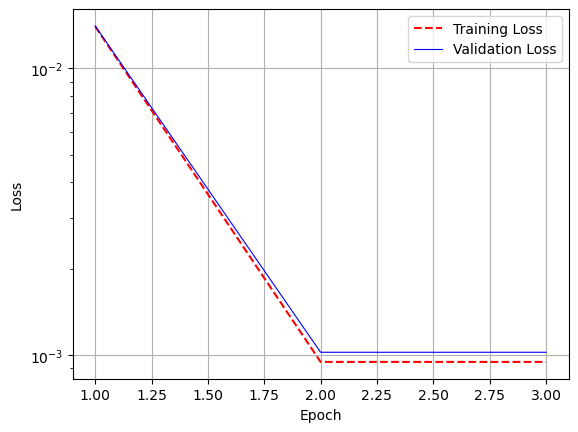

<Figure size 640x480 with 0 Axes>

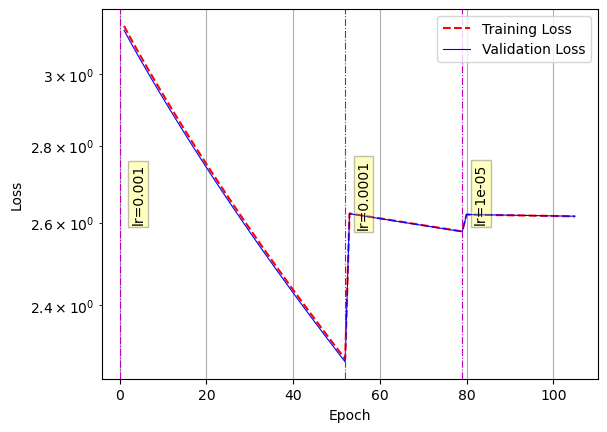

In [39]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=None,
    learning_rate_list=None
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history-preSGD.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()

if use_weights_post_dense == True:
    plt.clf()
    # Visualize loss history
    fig, ax = plot_losses(
        training_loss=train_loss_hist_sgd,
        val_loss=val_loss_hist_sgd,
        lr_change=lr_change_sgd,
        learning_rate_list=learning_rate_list_sgd
    )

    plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
    plt.show()

data_idx : 3


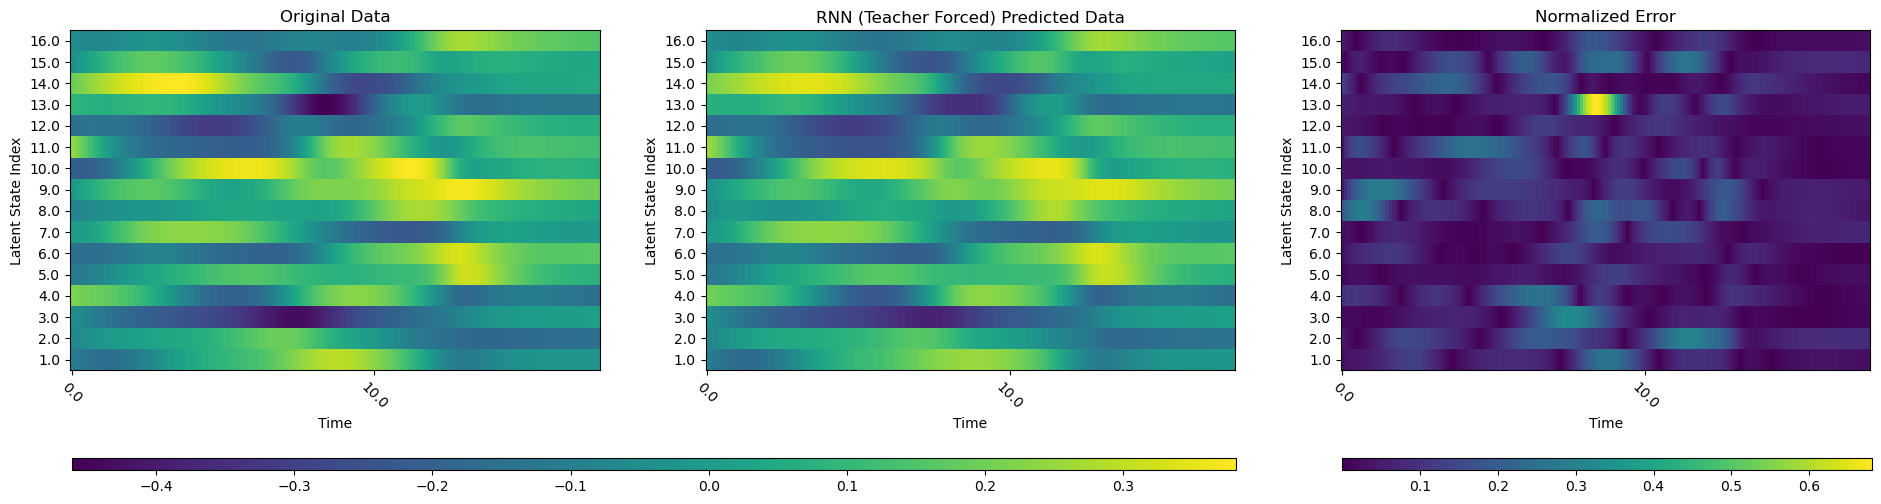

In [41]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx, 200:200+300]

for layer in rnn_net.ESN_layers:
    layer.reset_states()

prediction = np.array(rnn_net(data_in[data_idx:data_idx+batch_size_sgd, :, :], training=False))[:, 200:200+300, :]

for layer in rnn_net.ESN_layers:
    layer.reset_states()

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=10,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [42]:
prediction.shape, data_out.shape

((32, 175, 16), (175, 16))

In [43]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 20


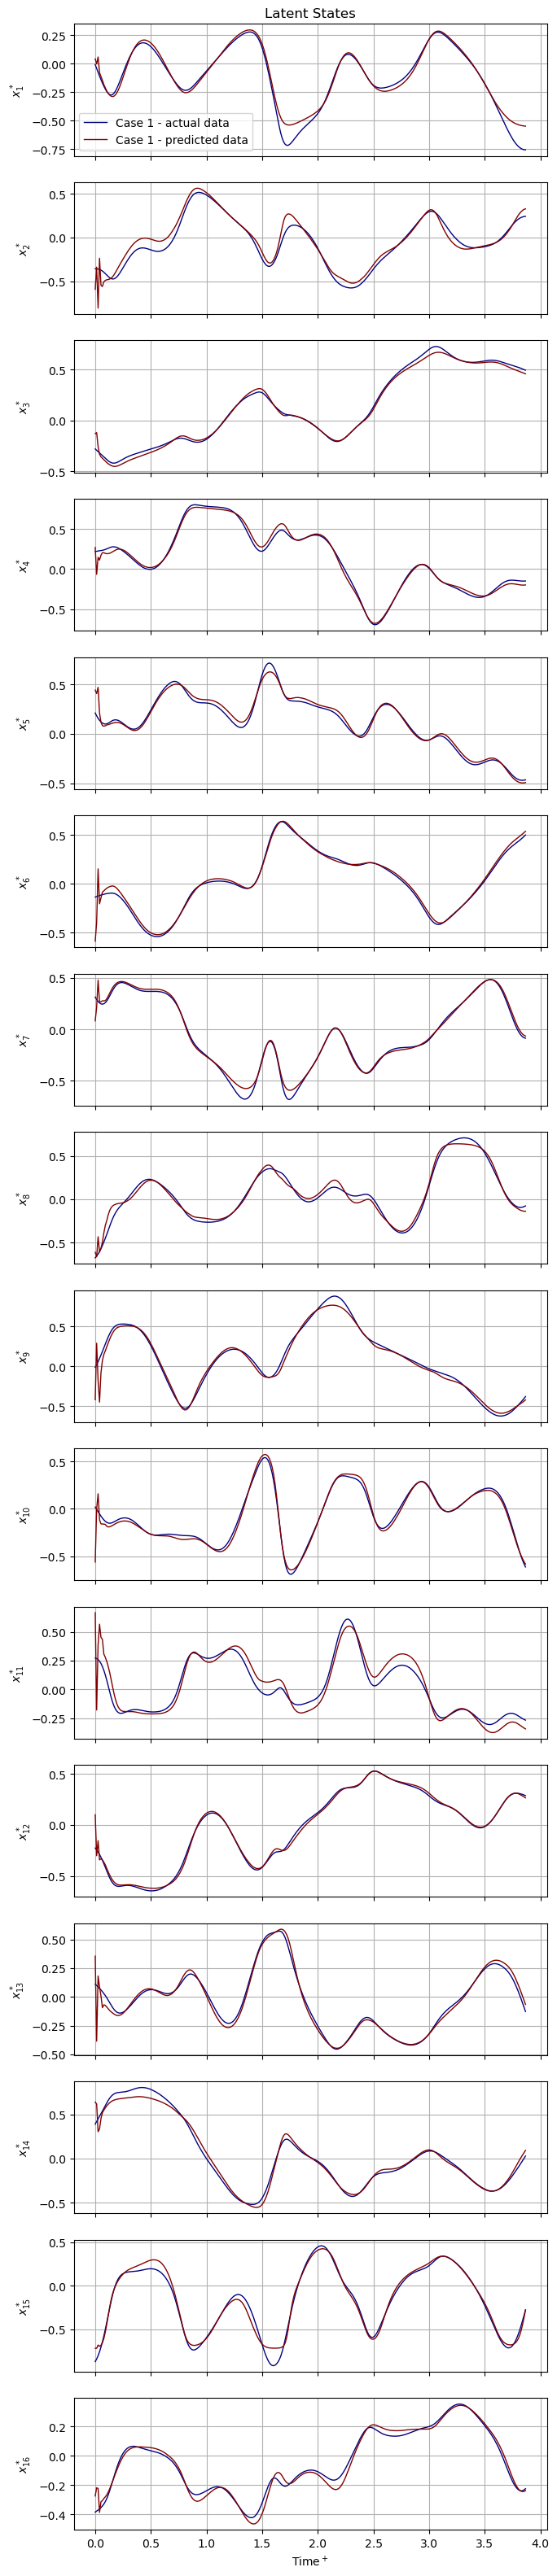


0.0


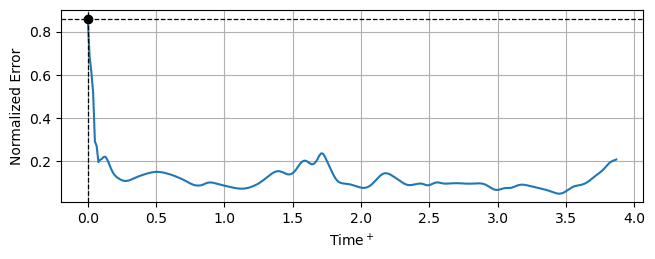

In [44]:
data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx][0:300]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)


for layer in rnn_net.ESN_layers:
    layer.reset_states()

# prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
prediction = np.array(rnn_net(data_in[data_idx:data_idx+batch_size_sgd, :, :], training=False))[:, 0:300, :]
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

for layer in rnn_net.ESN_layers:
    layer.reset_states()

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]

ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)



plt.show()

# Auto Regressive ESN

In [ ]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

In [ ]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 5*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

In [ ]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [ ]:
prediction_lst = []

for layer in rnn_net.ESN_layers:
    layer.reset_states()
    
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :], training=False))[0]

prediction_lst.append(input_preds[-1])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array([[prediction_lst[-1]]])
    output = np.array(rnn_net(data_in_i, training=False))[0, 0]
    prediction_lst.append(output)

In [ ]:
prediction_lst = np.stack(prediction_lst)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

In [ ]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [ ]:
if use_weights_post_dense == True:
    print(rnn_net.postWout.individual_weights)